In [75]:
#import librosa
import os
from os.path import isdir, join
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.io import wavfile
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [76]:
data_path_1 = 'spk1'
data_path_2 = 'spk2'


In [77]:
def load_speeches(path):
    waves = [f for f in os.listdir(path) if f.endswith('.wav')]
    labels = []
    samples_rate = []
    all_waves = []
    for wav in waves:
        sample_rate, samples = wavfile.read(join(path,wav))
        samples_rate.append(sample_rate)
        labels.append(wav[len(wav)-5])
        all_waves.append(samples)
    return all_waves ,samples_rate,labels


In [78]:
def get_spectrograms(waves):
    sample_rate = 8000
    spectros = []
    freqs = []
    tims = []
    for wav in waves:
        frequencies, times, spectrogram = signal.spectrogram(wav, sample_rate)
        freqs.append(frequencies)
        tims.append(times)
        spectros.append(spectrogram)
    return freqs,tims,spectros


In [79]:
all_waves_1,samples_rate_1,labels_1 = load_speeches(data_path_1)

all_waves_2,samples_rate_2,labels_2 = load_speeches(data_path_2)


In [80]:
max_sequence_len_1 = max([len(x) for x in all_waves_1])
max_sequence_len_2 = max([len(x) for x in all_waves_2])
max_sequence_len_1 ,max_sequence_len_2 


(91601, 107760)

In [81]:
all_waves_1 = np.array(pad_sequences(all_waves_1, maxlen=max_sequence_len_2, padding='post'))
all_waves_2 = np.array(pad_sequences(all_waves_2, maxlen=max_sequence_len_2, padding='post'))


In [82]:
all_waves =  np.vstack((all_waves_1,all_waves_2))


In [83]:
freqs,tims,spectros = get_spectrograms(all_waves)


In [84]:
spectros[1].shape


(129, 480)

In [85]:
spectros = np.array(spectros)


In [86]:
spectros.shape

(1170, 129, 480)

In [87]:
spectros = spectros.reshape(1170,129,480,1)

In [88]:
labels_1 = np.array(labels_1)
labels_2 = np.array(labels_2)


In [89]:
labels_1 = [1 for i in labels_1]

In [90]:
labels_2 = [0 for i in labels_2]

In [91]:
labels_1 = np.array(labels_1).reshape(640,1)

In [92]:
labels_2 = np.array(labels_2).reshape(-1,1)

In [93]:
labels = np.vstack((labels_1,labels_2))


In [94]:
labels.shape

(1170, 1)

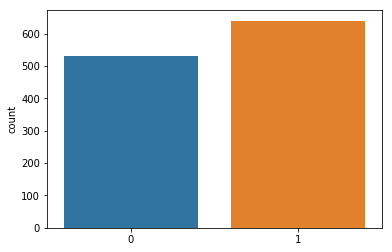

In [95]:
sns.countplot(labels.reshape(-1))

In [96]:
import keras
#labels = keras.utils.to_categorical(labels, 2)

In [97]:
from sklearn.model_selection import train_test_split
X, X_test, Y, Y_test = train_test_split(spectros, labels, test_size=0.2, random_state=42)

In [98]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
import tensorflow as tf

In [99]:
X.shape

(936, 129, 480, 1)

In [100]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (5,5), activation='relu',padding='same', input_shape=(X.shape[1], X.shape[2],1)),
  tf.keras.layers.Conv2D(32,(5,5), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout((0.25)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout((0.25)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout((0.5)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [101]:
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer = tf.keras.optimizers.Adam( epsilon=1e-08), loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 129, 480, 32)      832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 129, 480, 32)      25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 240, 32)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 240, 32)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 240, 64)       18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 240, 64)       36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 120, 64)      

In [103]:
model.fit(X,Y,batch_size=128,epochs=200,validation_data=(X_test,Y_test))

ValueError: You are passing a target array of shape (936, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.